# 10.7 Transformer

Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层。现在Transformer已经推广到各种现代深度学习中，例如语言、视觉、语音和强化学习


## 10.7.1 模型

编码器的结构从下到上依次为：
- 嵌入层：进行词嵌入
- 位置编码：sin cos
- 多头注意力
- 残差连接

解码器与此类似（详细见课本）

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 10.7.2 基于位置的前馈网络

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是一个多层感知机(MLP)，这就是称前馈网络是基于位置的原因。

以下代码的输入和输出：
- 输入：（批量大小，时间步数或序列长度，隐单元数或特征维度）
- 输出：（批量大小，时间步数，ffn_num_outputs）的输出张量

In [2]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN,self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input,ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens,ffn_num_outputs)

    def forward(self,X):
        return self.dense2(self.relu(self.dense1(X)))

改变张量的最内层维度的尺寸，会改变基于位置的前馈网络的输出尺寸

In [3]:
ffn = PositionWiseFFN(4,4,8)
ffn.eval()
ffn(torch.ones((2,3,4)))[0]

tensor([[-3.7991e-05, -1.0177e-01, -6.0197e-02, -1.1717e-01, -2.1172e-01,
         -5.2958e-01,  1.8521e-01, -1.5229e-01],
        [-3.7991e-05, -1.0177e-01, -6.0197e-02, -1.1717e-01, -2.1172e-01,
         -5.2958e-01,  1.8521e-01, -1.5229e-01],
        [-3.7991e-05, -1.0177e-01, -6.0197e-02, -1.1717e-01, -2.1172e-01,
         -5.2958e-01,  1.8521e-01, -1.5229e-01]], grad_fn=<SelectBackward0>)

## 10.7.3 残差连接和层规范化

层规范化和批量规范化的目标相同——对数据进行重新中心化和重新缩放。

但层规范化是基于特征维度进行规范化，更常用于自然语言处理；而批量规范化更常用于计算机视觉领域

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1,2],[2,3]],dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:',ln(X),'\nbatch norm:',bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用

In [5]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self,normalized_shape,dropout,**kwargs):
        super(AddNorm,self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self,X,Y):
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同

In [6]:
add_norm = AddNorm([3,4],0.5)
add_norm.eval()
add_norm(torch.ones((2,3,4)),torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

## 10.7.4 编码器

下面的EncoderBlock类包含两个子层：
- 多头自注意力
- 基于位置的前馈神经网络

In [9]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self,key_size,query_size,value_size,num_hiddens,
                 norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,
                 dropout,use_bais=False,**kwargs):
        super(EncoderBlock,self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size,query_size,value_size,num_hiddens,num_heads,dropout,
            use_bais)
        self.addnorm1 = AddNorm(norm_shape,dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input,ffn_num_hiddens,num_hiddens
        )
        self.addnorm2 = AddNorm(norm_shape,dropout)

    def forward(self,X,valid_lens):
        Y = self.addnorm1(X,self.attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))

In [10]:
X = torch.ones((2,100,24))
valid_lens = torch.tensor([3,2])
encoder_blk = EncoderBlock(24,24,24,24,[100,24],24,48,8,0.5)
encoder_blk.eval()
encoder_blk(X,valid_lens).shape

torch.Size([2, 100, 24])

下面实现的编码器代码中，堆叠了num_layers个EncoderBlock类的实例

In [16]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self,vocab_szie,key_size,query_size,value_size,
                 num_hiddens,norm_shape,ffn_num_input,ffn_num_hiddens,
                 num_heads,num_layers,dropout,use_bais=False,**kwargs):
        super(TransformerEncoder,self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_szie,num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens,dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size,query_size,value_size,num_hiddens,
                                              norm_shape,ffn_num_input,ffn_num_hiddens,
                                              num_heads,dropout,use_bais))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

下面创建一个两层的Transformer编码器，输出的形状为（批量大小，时间步数，num_hiddens）

In [17]:
encoder = TransformerEncoder(
    200,24,24,24,24,[100,24],24,48,8,2,0.5
)
encoder.eval()
encoder(torch.ones((2,100),dtype=torch.long),valid_lens).shape

torch.Size([2, 100, 24])

## 10.7.5 解码器

在DecoderBlock类中实现的层包含了三个子层：
- 解码器自注意力
- “编码器-解码器”自注意力
- 基于位置的前馈网络

这些子层也被残差连接和紧随的层规范化围绕

In [18]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器-解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens

In [19]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

最后，构建一个全连接层计算所有vocab_size个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化需要

In [20]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 10.7.6 训练



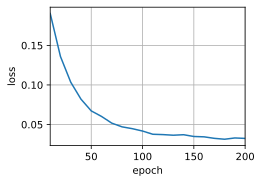

In [21]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用Transformer模型将一些英语句子翻译成法语，并计算它们的BLEU分数

In [22]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


翻译完成后，可视化Transformer的注意力权重，编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键-值”对的数目）


In [23]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

接下来，逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值得不同表示子空间来表示不同的注意力

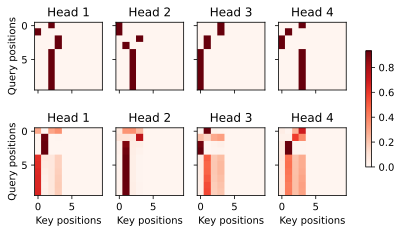

In [24]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [25]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的键-值对进行注意力计算

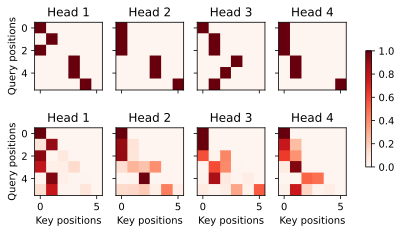

In [26]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

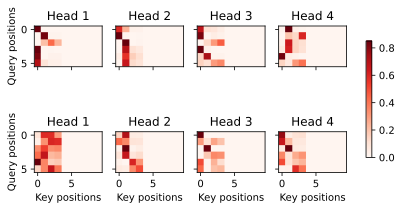

In [27]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管Transformer架构是为了*序列到序列*的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。

**总结**
- Transformer是编码器-解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用
- 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
- Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
- Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。